<a href="https://colab.research.google.com/github/jannajabel/ECE160-Waste_Classification/blob/main/Waste_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Thu May 19 06:27:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [5]:
!git clone https://github.com/jannajabel/ECE160-Waste_Classification.git

Cloning into 'ECE160-Waste_Classification'...
remote: Enumerating objects: 5502, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 5502 (delta 19), reused 11 (delta 6), pack-reused 5465
Receiving objects: 100% (5502/5502), 211.52 MiB | 44.08 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Checking out files: 100% (5081/5081), done.


In [6]:
#LOAD DATA
DIR = "/content/ECE160-Waste_Classification/Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5077 files belonging to 10 classes.
Using 4570 files for training.
Found 5077 files belonging to 10 classes.
Using 507 files for validation.
['Aluminum', 'Cardboard', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [7]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 200
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12697600/12683000 [==============================] - 0s 0us/step
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 36s 459ms/step - loss: 243.8042 - accuracy: 0.5350 - val_loss: 102.4148 - val_accuracy: 0.7594
Epoch 2/200
36/36 [==============================] - 16s 370ms/step - loss: 45.5798 - accuracy: 0.7788 - val_loss: 11.4493 - val_accuracy: 0.6489
Epoch 3/200
36/36 [==============================] - 16s 373ms/step - loss: 6.6211 - accuracy: 0.5731 - val_loss: 4.5804 - val_accuracy: 0.4517
Epoch 4/200
36/36 [==============================] - 16s 370ms/step - loss: 4.3115 - accuracy: 0.5057 - val_loss: 4.2241 - val_accuracy: 0.4536
Epoch 5/200
36/36 [==============================] - 16s 369ms/step - loss: 4.1892 - accuracy: 0.4849 - val_loss: 4.1945 - val_accuracy: 0.4398
Epoch 6/200
36/36 [==============================] - 16s 373ms/step - loss: 4.1711 - accuracy: 0.4816 - val_loss: 4.1570 - val_accuracy: 0.4418
Epoch 7/200
36/36 [==============================] - 16s 374ms/step - loss: 4.1370 - accuracy: 0.4891 - val_loss: 4.1146 - val_accuracy: 0.400

##**Model Evaluation**

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
model.save("/content/drive/MyDrive/Colab Notebooks/version_200epochs.h5")
new_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/version_200epochs.h5")
new_model.evaluate(test_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 3s 196ms/step - loss: 2.4759 - accuracy: 0.9112


[2.4759058952331543, 0.9112426042556763]

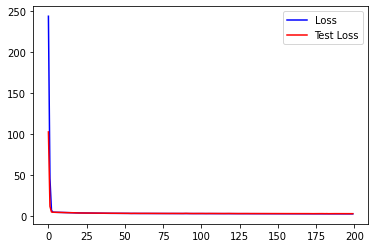

In [10]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/accuracy-version_200epochs.png')
plt.show()

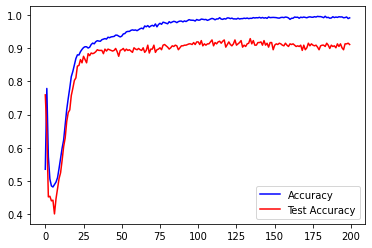

In [11]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/loss-version_200epochs.png')
plt.show()

Text(0, 0.5, 'Loss')

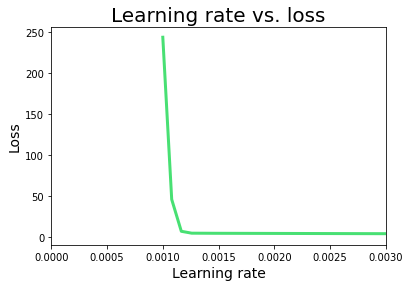

In [12]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

[1.1576707e-03 8.3067166e-03 6.3794483e-03 9.9904160e+01 7.8182397e-03
 8.4520653e-03 2.8707327e-03 5.5822212e-02 2.1897801e-03 2.8396156e-03] 
 ['Aluminum', 'Cardboard', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper', 'Plastic', 'Textiles', 'Wood']
Prediction:  Glass 99.90416169166565%


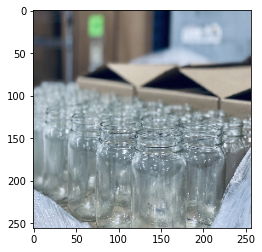

In [13]:
import requests

img_data = requests.get("https://media.npr.org/assets/img/2021/10/12/img-3809-3306227732c2415aedcd9ac88e0a5875f21d05f0.jpg").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

<Figure size 720x720 with 0 Axes>

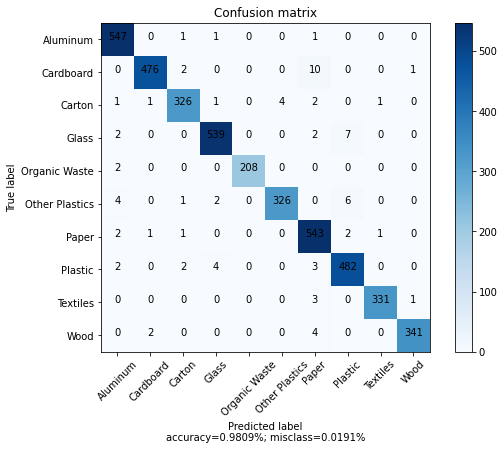

In [14]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/ECE160-Waste_Classification/Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)